In [3]:
## import public packages
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import mlab
from datetime import datetime
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.stats import multivariate_normal
# from __future__ import 
import torch
from torch.autograd import Variable

## import self-written packages 
from module_test import *
from util import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

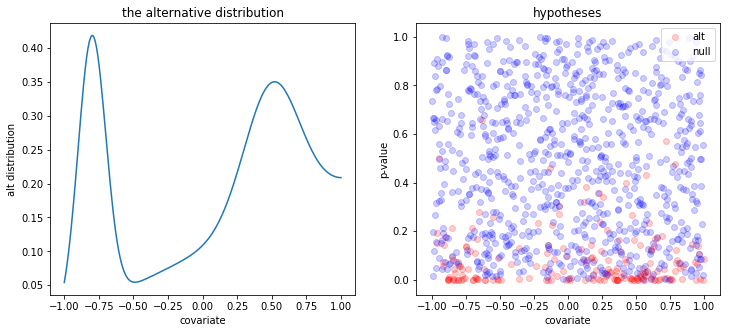

In [4]:
## generating a 1d toy data 
p,x,h=toy_data_1d(vis=1)

In [5]:
## testing the Storey BH method
n_rej,t_rej,pi0_hat=storey_bh(p,vis=1)

### Summary ###
method: Storey BH
# rejections: 613
rejection threshold: 0.00375359867915
null estimate: 0.8145
### End Summary ###


In [21]:
## maybe we should use pytorch
def perim_test_1d(p,x,alpha=0.05):    
    torch.manual_seed(42)
    n_itr    = 100
    L        = 2
    lambda0  = 0.1
    lambda1  = 1
    loss_rec = np.zeros([n_itr],dtype=float)
 
    p     = Variable(torch.from_numpy(p).float(),requires_grad=False)
    x     = Variable(torch.from_numpy(x).float(),requires_grad=False)
    
    ## initialization    
    a     = Variable(torch.Tensor([0.05]),requires_grad=True)
    b     = Variable(torch.Tensor([0]),requires_grad=True)
    w     = Variable(torch.rand(L),requires_grad=True)
    mu    = Variable(torch.rand(L)*2-1,requires_grad=True)
    sigma = Variable(torch.zeros(L)+0.1,requires_grad=True)
    
    optimizer = torch.optim.Adam([a,b,w,mu,sigma],lr=0.001)
    optimizer.zero_grad()
    
#     print('## initialization: ')
#     print ('a:',a)
#     print ('b:',b)
#     print ('w:',w)
#     print ('mu:',mu)
#     print ('sigma:',sigma)
    
    for l in range(n_itr):
        ## calculating the model
        t = x*b+a
        for i in range(L):
            t += w[i]*torch.exp(-(x-mu[i])**2/2/sigma[i]**2)
        t = t.clamp(min=0)

        loss = -torch.mean(torch.sigmoid(lambda0*(t-p)))+lambda1*(torch.mean(t)-alpha)*((torch.mean(t)-alpha)>0).float()
        
        ## backprop
        loss.backward()
        optimizer.step()
        
        ## show the result 
        loss_rec[l] = loss.data.numpy()
        
        if l%10==0:
            plt.figure()
            plot_t(t.data.numpy(),x.data.numpy())
            plt.show()
    
    
    plt.figure()
    plt.plot(loss_rec)
    plt.show()
    
    p = p.data.numpy()
    t = t.data.numpy()
    n_rej=np.sum(p<t)    
        
    return n_rej,t

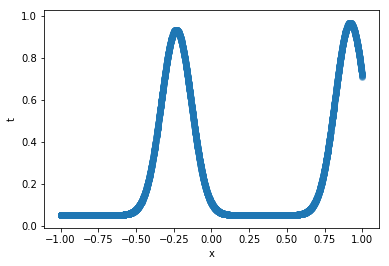

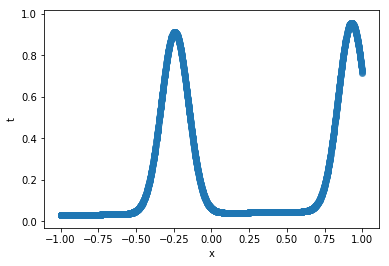

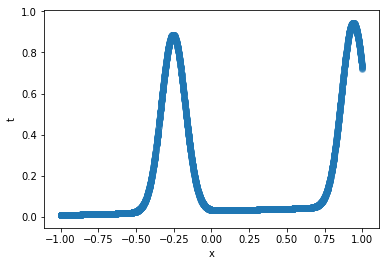

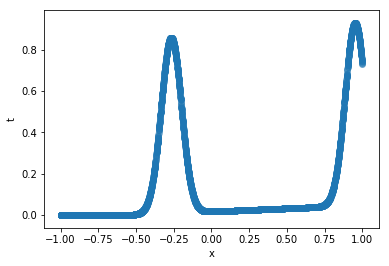

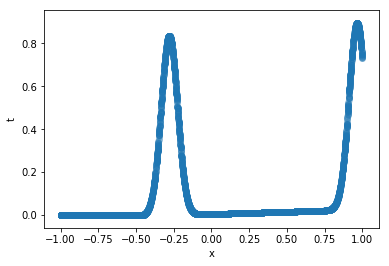

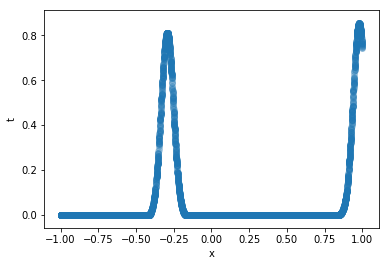

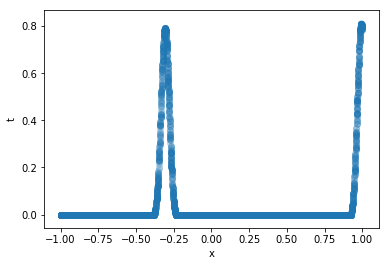

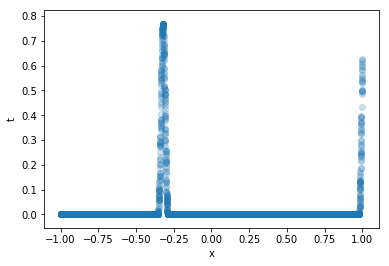

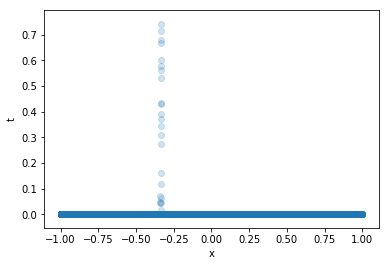

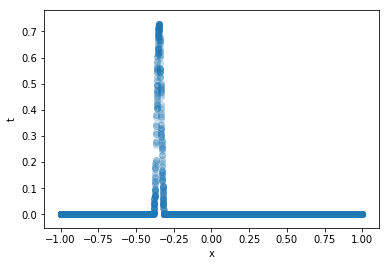

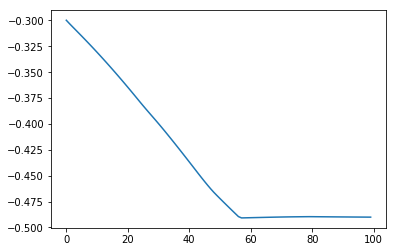

### Summary ###
method: perim_test_1d
# rejections: 190
FDP: 0.884210526316
### End Summary ###


In [22]:
n_rej,t=perim_test_1d(p,x,alpha=0.05)

print("### Summary ###")
print("method: perim_test_1d")
print("# rejections: %s"%str(n_rej))
print("FDP: %s"%str( np.sum((h==0)*(p<t))/np.sum(p<t)))
print("### End Summary ###")

In [10]:
def plot_t(t,x):
    plt.scatter(x,t,alpha=0.2)
    plt.ylabel('t')
    plt.xlabel('x')